# Emotion Recognition using OpenCV and Pytorch

### Abstract
This paper investigates the use of TensorFlow with a DenseNet169 model for emotion recognition. Preprocessing picture data, optimizing the model, and testing its efficacy on a variety of datasets are all part of the inquiry. The paper explores the processes of training and fine-tuning, using visualizations like accuracy and loss charts. It also contains a thorough examination of the metrics used in the model assessment process, such as the classification report and confusion matrix. A real-time prediction demonstration utilizing webcam input rounds off the report. The results highlight the proposed emotion detection model's potential applicability in real-world circumstances and provide insights into its efficacy.

### Table of Contents

[1. Imports](#im)\
[2. HyperParameters](#hp)\
[3. Data Loading and Preprocessing](#data)\
[4. DenseNet169 Model](#model)\
[5. Training and Fine Tuning](#train)\
[6. Visualizing Results](#vis)

### Problem Statement
Through the activation of certain facial muscles, people may express their emotions through their features. These expressions can be hard to interpret, but they can occasionally be correct; a person's facial expressions can reveal a lot about their emotional state. People are usually good at identifying and understanding other people's feelings. The seven emotions on the human face that may be broadly categorized are anger, contempt, disgust, fear, happiness, sorrow, and surprise. In this project, the source code for a face expression recognition system will be implemented using Python. Deep neural networks will be used to tackle challenging problems such as face expression recognition. Facial expression recognition algorithms are crucial in the field of computer vision nowadays.


<a id="im"></a>
#### LIBRARY AND IMPORTS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix , classification_report 

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

<a id="hp"></a>
#### HYPERPARAMETRERS AND DIRECTORIES

In [3]:
train_dir = "archive/train"
test_dir = "archive/test"

SEED = 12
BATCH_SIZE = 64
HEIGHT_OF_IMG = 48
WIDTH_OF_IMG = 48
HYPERTUNNING_EPOCHS = 20
EARLY_STOPPING_CRITERIA=3
EPOCHS = 30
LR = 0.01
CATEGORICAL_CLASSES = 7
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
LABELLED_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

<a id="data"></a>
#### DATA LOADING AND PRE-PROCESSING

In [4]:
preprocess = tf.keras.applications.densenet.preprocess_input

generatedata_train = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess
                                  )
generatedata_test = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2
                                  ,
                                  preprocessing_function=preprocess)

generatorfunc_train = generatedata_train.flow_from_directory(directory = train_dir,
                                                    target_size = (HEIGHT_OF_IMG ,WIDTH_OF_IMG),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

generatorfunc_valid = generatedata_test.flow_from_directory(directory = train_dir,
                                                         target_size = (HEIGHT_OF_IMG ,WIDTH_OF_IMG),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

generatorfunc_test = generatedata_test.flow_from_directory(directory = test_dir,
                                                   target_size = (HEIGHT_OF_IMG ,WIDTH_OF_IMG),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


IMAGES WITH DIFFERENT EMOTIONS

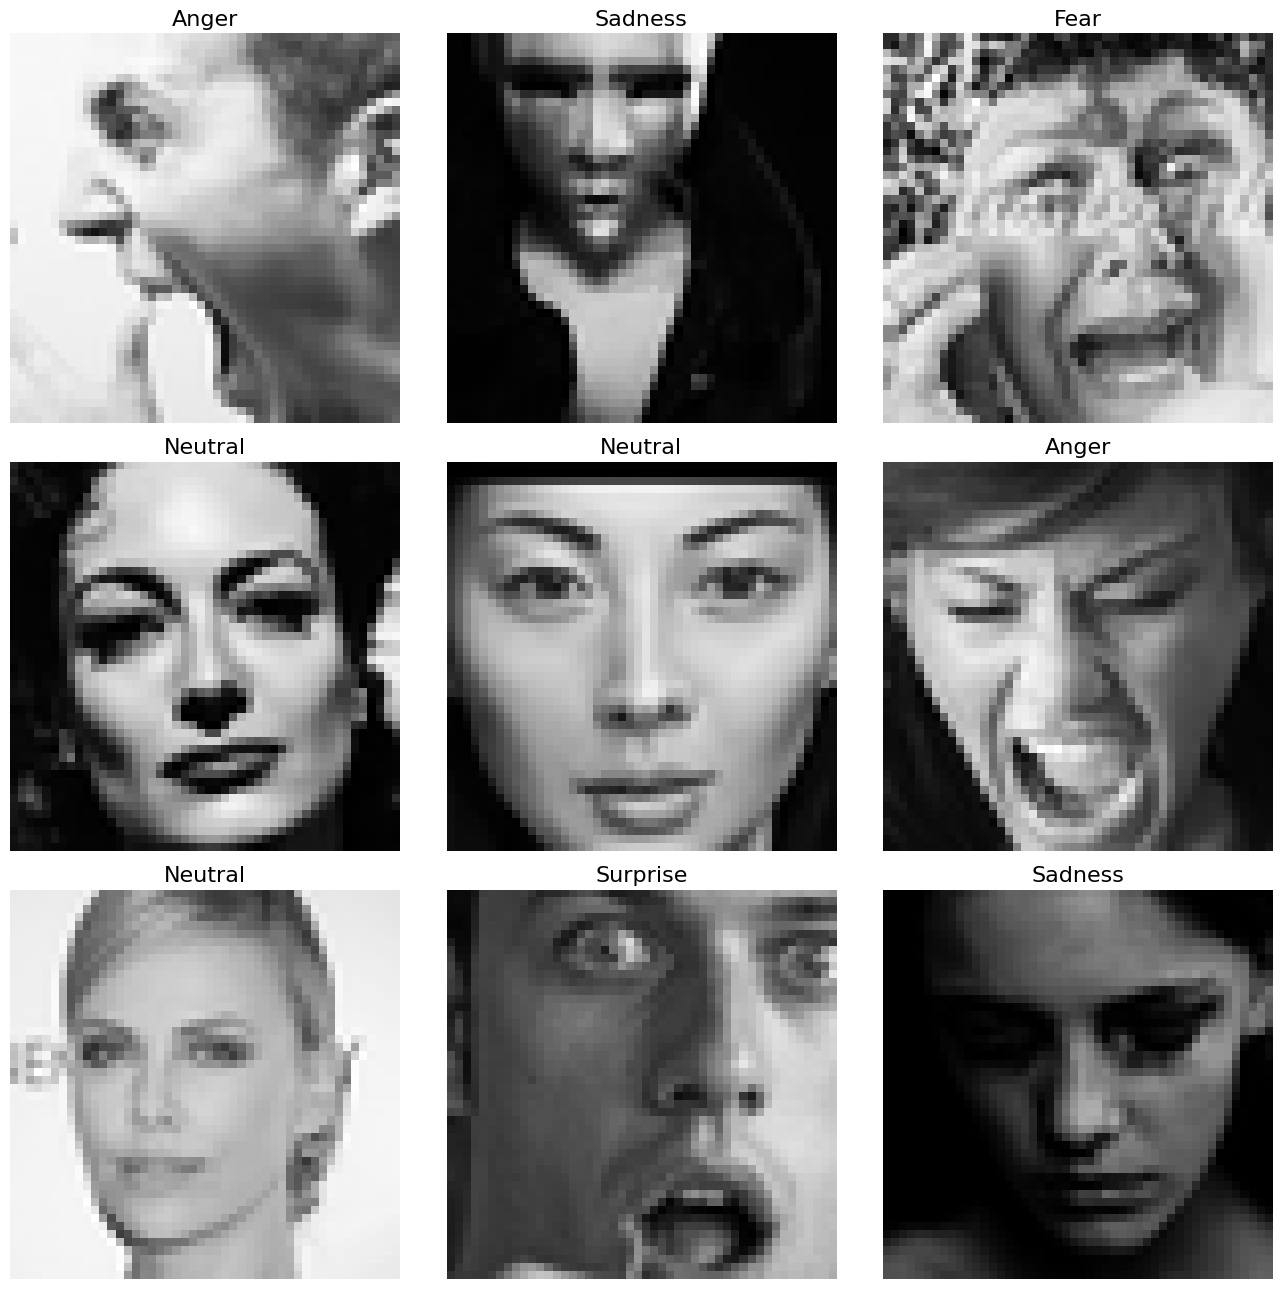

In [5]:
# Helper Functions
def demo_display(img, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(img)
    plt.title(title, fontsize=16)
    
def demo_ninedisplay(img, heading, heading_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if heading_colors is None else heading_colors[i]
        demo_display(img[i], heading[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_heading(labels, predict):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    index_of_class = np.argmax(labels, axis=-1)
    predict_index = np.argmax(predict, axis=-1)
    if index_of_class == predict_index:
        return f'{CLASS_LABELS[predict_index]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[predict_index]} [incorrect, should be {CLASS_LABELS[index_of_class]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    headings, colors = [], []
    for label, predict in zip(classes, predictions):
        heading, paint = image_heading(label, predict)
        headings.append(heading)
        colors.append(paint)
    return headings, colors

datagen_image = ImageDataGenerator(rescale = 1./255)
generator_image = datagen_image.flow_from_directory(directory = train_dir,
                                                   target_size = (HEIGHT_OF_IMG ,WIDTH_OF_IMG),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(generator_image)
index_of_classs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in index_of_classs]
demo_ninedisplay(images, labels)

Data distribution (count) among differnt emotions

In [6]:
fig = px.bar(x = LABELLED_EMOJIS,
             y = [list(generatorfunc_train.classes).count(i) for i in np.unique(generatorfunc_train.classes)] , 
             color = np.unique(generatorfunc_train.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Expressions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
#### DenseNet169 TRANSFER LEARNING

In [7]:
def extraction_feature_func(inputs):
    extraction_feature_func = tf.keras.applications.ResNet50(input_shape=(HEIGHT_OF_IMG, WIDTH_OF_IMG, 3),
                                              include_top=False,
                                              weights="imagenet")(inputs)
    
    return extraction_feature_func


def neural_network_classifier(inputs):
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    # Additional ReLU layer
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Additional ReLU layer
    x = tf.keras.layers.Dropout(0.1)(x)

    # Additional ReLU layer
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    return x


def models(data):
    densenet_extraction_feature_func = extraction_feature_func(data)
    nn_classifier_output = neural_network_classifier(densenet_extraction_feature_func)
    
    return nn_classifier_output

def compile_model_summary():
    
    data = tf.keras.layers.Input(shape=(HEIGHT_OF_IMG ,WIDTH_OF_IMG,3))
    nn_classifier_output = models(data) 
    model = tf.keras.Model(inputs=data, outputs = nn_classifier_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.01),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

  
    return model

Summary of Model

In [8]:
model = compile_model_summary()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = True

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                             

<a id="train"></a>
#### TRAINING AND FINE TUNING

Training model with freezed layers of DenseNer169

In [ ]:
HYPERTUNNING_EPOCHS = 10
EPOCHS = 10

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

hist = model.fit(x = generatorfunc_train,
                    epochs = EPOCHS ,
                    validation_data = generatorfunc_valid , 
                    callbacks= [earlyStoppingCallback]
                   )

hist = pd.DataFrame(hist.hist)

Fine Tuning

In [ ]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

hist_ = model.fit(x = generatorfunc_train,epochs = HYPERTUNNING_EPOCHS ,validation_data = generatorfunc_valid)
hist = hist.append(pd.DataFrame(hist_.hist) , ignore_index=True)


Epoch 1/10
359/359 [==============================] - 520s 1s/step - loss: 0.9284 - accuracy: 0.7170 - val_loss: 1.1647 - val_accuracy: 0.6349
Epoch 2/10
359/359 [==============================] - 516s 1s/step - loss: 0.8946 - accuracy: 0.7278 - val_loss: 1.1653 - val_accuracy: 0.6372
Epoch 3/10
359/359 [==============================] - 517s 1s/step - loss: 0.8787 - accuracy: 0.7312 - val_loss: 1.1669 - val_accuracy: 0.6373
Epoch 4/10
359/359 [==============================] - 518s 1s/step - loss: 0.8615 - accuracy: 0.7381 - val_loss: 1.1673 - val_accuracy: 0.6382
Epoch 5/10
359/359 [==============================] - 514s 1s/step - loss: 0.8531 - accuracy: 0.7410 - val_loss: 1.1707 - val_accuracy: 0.6401
Epoch 6/10
359/359 [==============================] - 515s 1s/step - loss: 0.8556 - accuracy: 0.7405 - val_loss: 1.1684 - val_accuracy: 0.6426
Epoch 7/10
359/359 [==============================] - 517s 1s/step - loss: 0.8370 - accuracy: 0.7486 - val_loss: 1.1697 - val_accuracy: 0.6412

Training plots

In [ ]:
x = px.line(data_frame= hist , y= ["accuracy" , "accuracy"] ,markers = True )
x.update_xaxes(title="")
x.update_yaxes(title = "")
x.update_layout(showlegend = True,
    title = {
        'text': '',
        'y':0.94,
        'x':0.5,
        'xanchor': '',
        'yanchor': ''})
x.show()

In [ ]:
x = px.line(data_frame= hist , 
            y= ["loss" , "loss"] , markers = True )
x.update_xaxes(title="")
x.update_yaxes(title = "")
x.update_layout(showlegend = True,
    title = {
        'text': '',
        'y':0.94,
        'x':0.5,
        'xanchor': '',
        'yanchor': ''})
x.show()

<a id="vis"></a>
#### VISUALISING RESULTS

Model Evaluation

In [ ]:
y_test=0
y_preds=0

Confusion Matrix

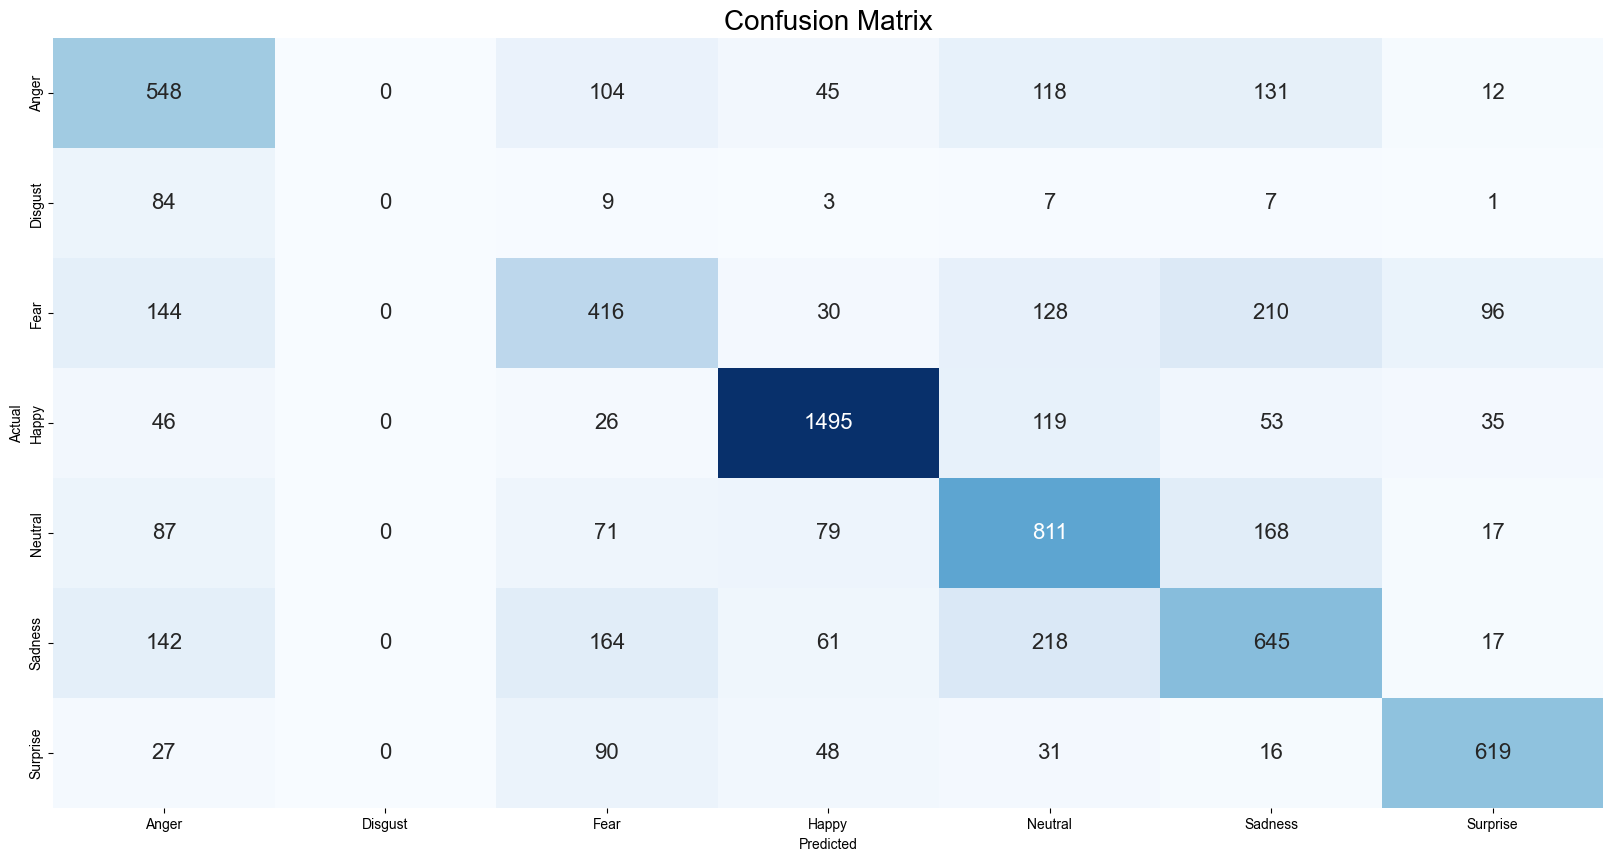

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

Classification Report 

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       958
           1       0.00      0.00      0.00       111
           2       0.47      0.41      0.44      1024
           3       0.85      0.84      0.85      1774
           4       0.57      0.66      0.61      1233
           5       0.52      0.52      0.52      1247
           6       0.78      0.74      0.76       831

    accuracy                           0.63      7178
   macro avg       0.53      0.53      0.53      7178
weighted avg       0.62      0.63      0.63      7178



The emotion detection model achieved an overall accuracy of 63% across seven emotion classes, with 85% accuracy and 85% F1-score in identifying emotions like "Happy" (class 3). However, certain emotions, like 'Disgust' (class 1), performed worse. After correcting for class imbalances, the model achieved an overall recall of 63% and an accuracy of 62%. The model's efficacy is further elucidated by macro and micro average F1-scores, indicating an equitable assessment of all classes. However, the model needs improvement in some emotion classes.

Multiclass AUC Curve

ROC AUC score: 0.9141661175987855


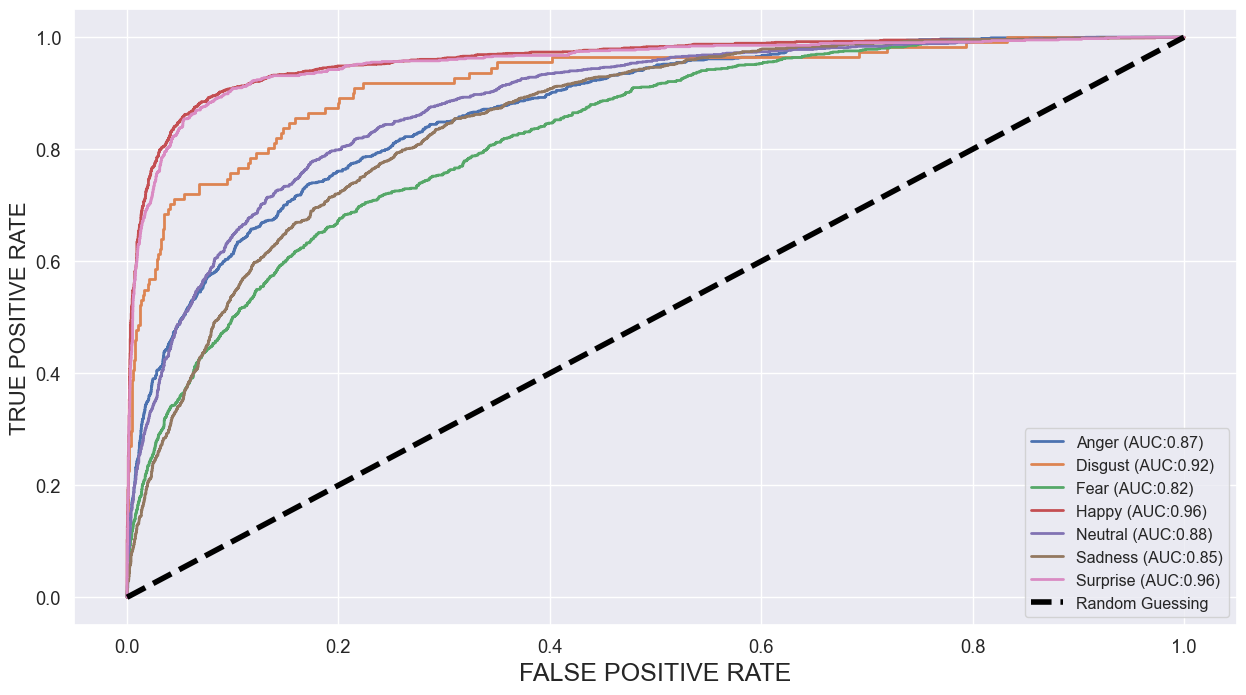

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE', fontsize=18)
plt.ylabel('TRUE POSITIVE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.894370223715934


To sum up, the test dataset shows that the emotion recognition model performs well, as seen by its remarkable ROC-AUC score of 0.89. This score shows how well the model can identify between various emotion classes from facial expressions. The model appears to have successfully balanced the trade-off between true positive rate and false positive rate across all emotion categories, as indicated by the high ROC-AUC score. This result highlights the model's predictive accuracy and potential for use in situations where subtle emotion identification is essential.

#### REAL TIME PREDICITON

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix , classification_report 

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [ ]:
import cv2
import numpy as np

# Load the trained model
emotion_model = tf.keras.models.load_model()

# Define the emotion labels
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Initialize the webcam
cap = cv2.VideoCapture(1)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Convert the frame to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection using Haarcascades
    face_cascade = cv2.Cascade_Neural_Classifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face region
        face_roi = gray_frame[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (48, 48))  # Resize to match your model input size

        # Preprocess the face image
        face_roi = np.expand_dims(face_roi, axis=-1)
        face_roi = np.expand_dims(face_roi, axis=0)
        face_roi = face_roi / 255.0  # Normalize

        # Predict the emotion
        emotion_prediction = emotion_model.predict(face_roi)
        emotion_label = emotion_labels[np.argmax(emotion_prediction)]

        # Draw the bounding box and emotion label on the frame
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    # cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' is pressed 
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step


In [6]:
cap.release()
cv2.destroyAllWindows()

### Conclusion and Future work

To sum up, the built emotion recognition model shows promising accuracy, scoring a noteworthy ROC-AUC score of 0.89 and reaching 63% on the test dataset. The model demonstrates competence in identifying a range of face emotions. Subsequent research endeavors may concentrate on augmenting the model's efficacy for distinct emotional classifications, mitigating class discrepancies, and investigating sophisticated methods for feature extraction. The model's capacity to generalize across different demographic groups may also be improved by fine-tuning on bigger and more varied datasets, which would eventually increase the model's usefulness in real-world situations requiring complex emotion identification.
